# Monte Carlo percolation simulations

This notebook is just a high-level summary of my work on Monte Carlo simulations of charge hopping in $40\,\text{nm}\times40\,\text{nm}$ MAC.

## MC alogrithm overview

The MC algorithm estimates the 'percolation time' for an electron in MAC (i.e. the time it takes for an electron to go from from an unoccupied orbital which is strongly coupled to the lead connected to the structure's left edge to an unocccupied orbital which is strongly coupled to the lead connected to the right edge).

Here are the main steps of the algo:


1. Define $\mathcal{L_{MO}}$ and $\mathcal{R_{MO}}$, the sets of MOs that are "strongly coupled" to the left and right electrodes, respectively. This is done by computing $\langle\Gamma_L\rangle$ and $\langle\Gamma_R\rangle$ for all MOs. We then define $\mathcal{L_{MO}}$ and $\mathcal{R_{MO}}$ as follows; for $\alpha = L,R$: $\mathcal{A}_{MO} = \{ |\psi\rangle : \langle\psi|\Gamma_{\alpha}|\psi\rangle > \bar{\Gamma}_{\alpha} + c*\sigma_{\alpha}\}$, where $\bar{\Gamma}_{\alpha}$ and $\sigma_{\alpha}$ are the average and standard deviation of $\langle\Gamma_{\alpha}\rangle$ (resp.) for all considered MOs of the structure at hand, and $c$ is some scaling constant (we choose $c = 3$).

2. Discretise the MOs of interest (i.e. $\sim 100$ lowest unoccupied MOs obtained from ArpackMAC code) into 'hopping sites', using procedure from `percolate` module (`generate_site_list` function). From there define $\mathcal{L}$ and $\mathcal{R}$, the sets of sites obtained by discretising MOs in $\mathcal{L_{MO}}$ and $\mathcal{R_{MO}}$, respectively. 

3. Pick values for the temperature $T$, reorganisation energy $\lambda$, and the electric field $\bm{E}$.

4. Compute hopping rates $k_{ij}$ between all pairs of sites $(i,j)$.

5. Commence MC hopping:

    1. Pick a random site $s_0\in\mathcal{L}$.
    
    2. While $s_{n}\notin\mathcal{R}$:
        
        * Calculate MC hopping times between $s_{n}$ and all other sites $j$ as follows: $\tau_{s_n,j} = - k_{s_n,j}^{-1}\ln x_j$, where $x_j$ is random number uniformly sampled from $(0,1]$.

        * $s_{n+1} = \text{argmin}_j\{\tau_{s_n,j}\}$

        * $\tau \leftarrow \tau + \tau_{s_n,j}$ ; $n \leftarrow n+1$ 

We repeat this procedure 1000 times for each structure.

For the first part of our investigation we calculate the rates using the Marcus equation:

$$
k_{ij} = \frac{2\pi}{\hslash}\,|H_{ij}|^2\,\sqrt{\frac{1}{4\pi\lambda k_{B}T}}\,\text{exp}\left\{ \frac{-(\lambda + \varepsilon_j - \varepsilon_i + e\,\bm{E}\cdot (\bm{r}_j - \bm{r}_i))^2}{4\lambda k_B T} \right\}
$$

Here are the results for a typical MAC structure. We repeat this procedure 1000 times and report the average percolation time $\langle\tau\rangle$.

(87,)


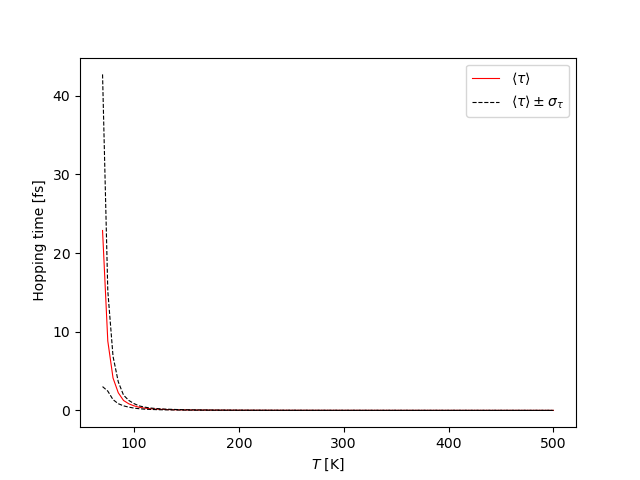

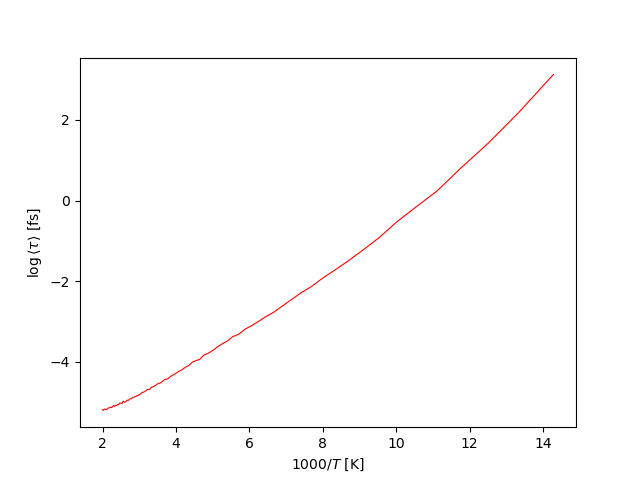

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from glob import glob

%matplotlib widget

tpercdir = "/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/marcus/percolation_times_dipole/MC_1000/"
dipfiles = glob(tpercdir + "dip*npy")

temps = np.arange(70,505,5,dtype=np.float64)

times = np.zeros_like(temps)
sample_ind = 9
dat = np.load(dipfiles[sample_ind])
times = np.mean(dat,axis=0)
print(times.shape)
sigma = np.std(dat,axis=0)

# Regular plot
plt.figure()
plt.plot(temps, times, 'r-', lw=0.8,label="$\langle \\tau\\rangle$")
plt.plot(temps, times+sigma, 'k--', lw=0.8,label="$\langle \\tau\\rangle\pm\sigma_\\tau$")
plt.plot(temps, times-sigma, 'k--', lw=0.8)
plt.xlabel("$T$ [K]")
plt.ylabel(" Hopping time [fs]")
plt.legend()
plt.show()

# Arrhenius plot
plt.figure()
plt.plot(1000/temps, np.log(times), 'r-', lw=0.8)
plt.xlabel("$1000/T$ [K]")
plt.ylabel("$\log\langle \\tau\\rangle$ [fs]")
plt.show()

The predicted percolation is $\tau\approx 0\,\text{fs}$ for $T \gtrsim 100,\text{K}$. This is obviously ludicrous. What causes our predicted percolation time to be so small? 

Perhaps the electric field term in the exponent of the Marcus rate makes our values of $k_{ij}$ too large -- thereby leading to unphysically short percolation times. Below is our result for the same structure, with no external field (i.e. $\bm{E} = \textbf{0}$), and 100000 MC iterations.

(87,)


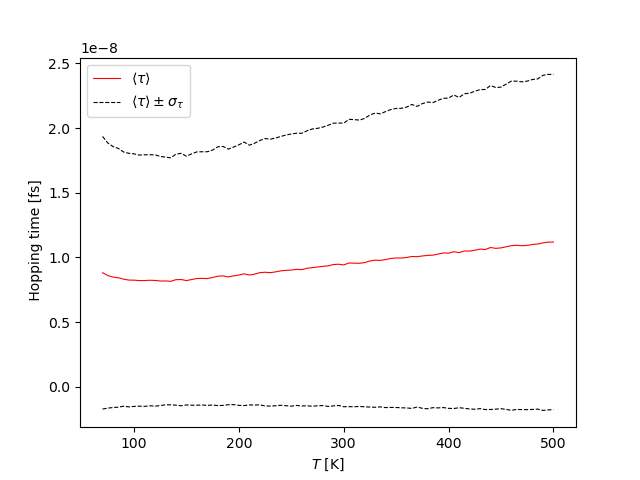

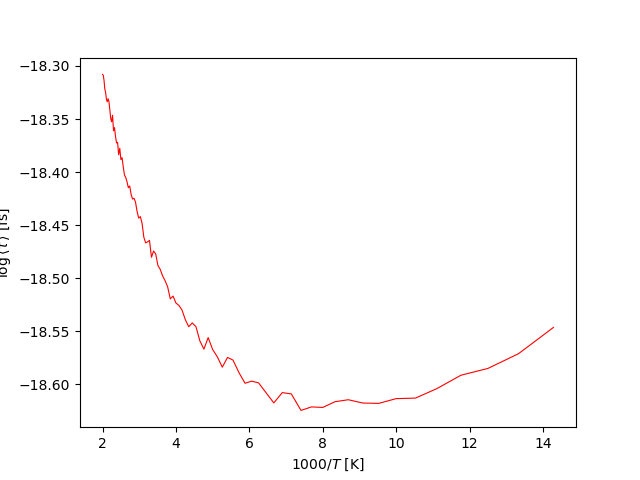

In [3]:

tpercdir = "/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/marcus/percolation_times_dipole/MC_100000/zero_ext_field/"
dipfiles = glob(tpercdir + "dip*npy")

temps = np.arange(70,505,5,dtype=np.float64)

times = np.zeros_like(temps)
sample_ind = 9
dat = np.load(dipfiles[sample_ind])
times = np.mean(dat,axis=0)
print(times.shape)
sigma = np.std(dat,axis=0)

# Regular plot
plt.figure()
plt.plot(temps, times, 'r-', lw=0.8,label="$\langle \\tau\\rangle$")
plt.plot(temps, times+sigma, 'k--', lw=0.8,label="$\langle \\tau\\rangle\pm\sigma_\\tau$")
plt.plot(temps, times-sigma, 'k--', lw=0.8)
plt.xlabel("$T$ [K]")
plt.ylabel(" Hopping time [fs]")
plt.legend()
plt.show()

# Arrhenius plot
plt.figure()
plt.plot(1000/temps, np.log(times), 'r-', lw=0.8)
plt.xlabel("$1000/T$ [K]")
plt.ylabel("$\log\langle \\tau\\rangle$ [fs]")
plt.show()

These results are even worse. There is likely a bug in our MC procedure. To investigate this, we start by plotting the rate matrix. We set the diagonal elements to $k_{jj} = 0$ since we do not allow hopping to the same in our algorithm.

/Users/nico/Desktop/scripts/percolate_mac/monte_carlo.py:183: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  out[i,j] = 2 * np.pi * Js[i,j]* Js[i,j] * np.exp(-(e_reorg + energies[j] - energies[i] - e * np.dot(E,(pos[j] - pos[i])))**2/A) / (hbar * np.sqrt(np.pi * A))


(57778, 122)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Entering triple for-loop...
Done!
Evaluating Marcus rates...
Done!
Fraction of zero elements = 0/42849


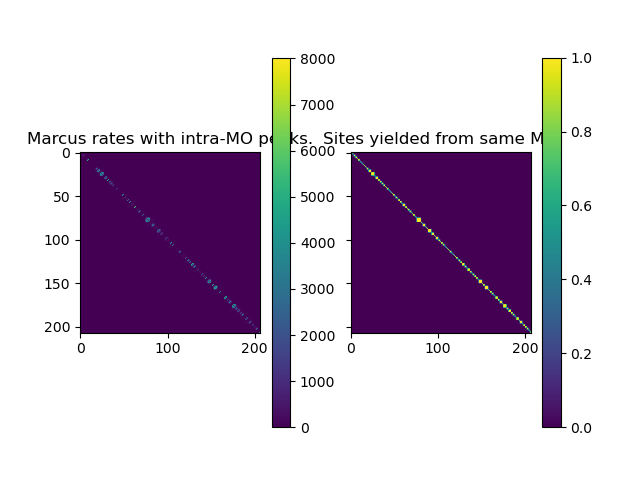

In [ ]:
from os import path
from monte_carlo import kMarcus_njit, dipole_coupling


nsample = 150

percolate_datadir = f'/Users/nico/Desktop/simulation_outputs/percolation/40x40/percolate_output/sample-{nsample}/'
M = np.load(f'/Users/nico/Desktop/simulation_outputs/percolation/40x40/MOs_ARPACK/MOs_ARPACK_bigMAC-{nsample}.npy')
MO_energies = np.load(f'/Users/nico/Desktop/simulation_outputs/percolation/40x40/eARPACK/eARPACK_bigMAC-{nsample}.npy')
strucdir = '/Users/nico/Desktop/simulation_outputs/percolation/40x40/structures/'
print(M.shape)

centers = np.load(percolate_datadir + 'cc.npy')
site_energies = np.load(percolate_datadir + 'ee.npy')
site_inds = np.load(percolate_datadir + 'ii.npy')

sites_data = (centers, site_energies, site_inds)

gamL = np.load(percolate_datadir + f'gamL_40x40-{nsample}.npy')
gamR = np.load(percolate_datadir + f'gamR_40x40-{nsample}.npy')

MO_gams = (gamL, gamR)

pos = np.load(f'pos-{nsample}_nodangle.npy')


temps = np.arange(100,300,100,dtype=np.float64)

# dX = np.max(pos[:,0]) - np.min(pos[:,1])

# E = np.array([1.0,0]) / dX # Efield corresponding to a voltage drop of 1V accross MAC sample 
E = np.zeros(2)
e_reorg = 0.005


Js = dipole_coupling(M,pos,site_inds)/100
np.save(f"/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/dipole_couplings/local/Jdip-{nsample}_local.npy", Js)

# Js = np.load(f"/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/dipole_couplings/Jdip-{nsample}.npy")

# dE = site_energies[None,:] - site_energies[:,None]
# #dE[np.abs(dE) == 0] = 1e-6



K = kMarcus_njit(site_energies,centers,0.005,Js,100,E)
# K = np.load(f'kMarcus-{nsample}.npy')

K0d = np.copy(K)
np.fill_diagonal(K0d, 0)

fig, axs = plt.subplots(1,2,sharey=True)

pcm = axs[0].imshow(K0d)
axs[0].set_title("Marcus rates with intra-MO peaks.")
fig.colorbar(pcm, ax = axs[0])


same_MO = site_inds == site_inds[:,None]

pcm = axs[1].imshow(same_MO)
axs[1].set_title("Sites yielded from same MO")
fig.colorbar(pcm, ax = axs[1])

plt.show()

The rate matrix is dominated by elements corresponding to hops between sites yielded by the same MO. Since these hops are unphysical, we set them to 0 and re-plot the rate matrix.

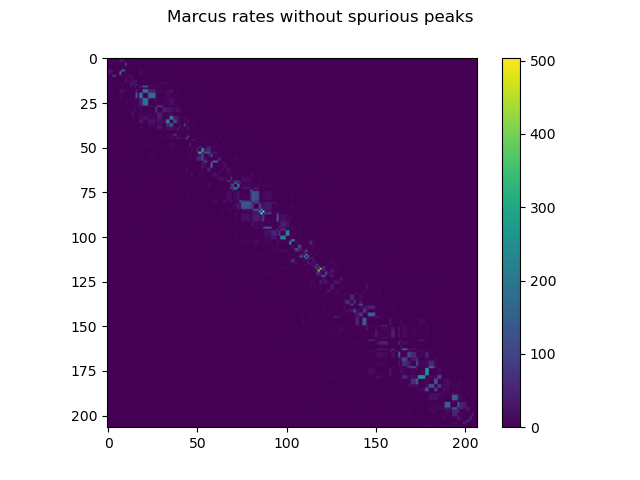

In [ ]:

from monte_carlo import zero_intraMO_rates

K2 = zero_intraMO_rates(K, site_inds)
plt.figure()
plt.imshow(K2)
plt.colorbar()
plt.suptitle("Marcus rates without spurious peaks")
plt.show()

We also plot the log of this recitfied rate matrix to get a a better sense of how the elements far from the main diaginal behave.

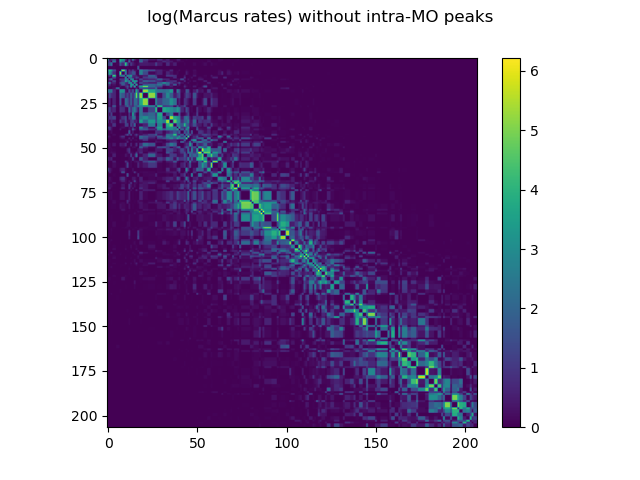

In [ ]:
plt.figure()
plt.imshow(np.log(K2+1.0))
plt.colorbar()
plt.suptitle("log(Marcus rates) without intra-MO peaks")
plt.show()

So we still have some very high rates, even with no external electric field. Let's check out the other terms in the Marcus expression.
We start with the energy differences.

Maximum energy difference [eV] =  0.03877570841430546
Minimum energy difference [eV] =  1.2103200938973213e-06


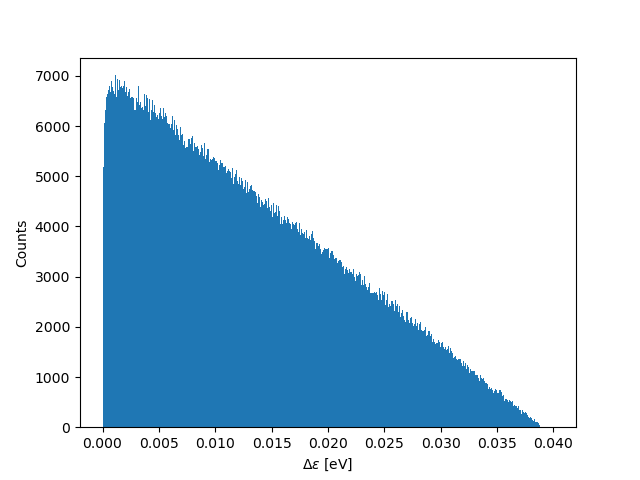

In [ ]:
datadir = path.expanduser('~/Desktop/simulation_outputs/percolation/40x40/')
energy_dir = datadir + 'eARPACK/'
mo_dir = 'MOs_ARPACK'
pos_dir = 'structures'

efiles = glob(energy_dir + '*')

bins = np.linspace(0,0.04,1001)
hist = np.zeros(1000,dtype=float)
max_dE = 0
min_dE = np.inf

for ef in efiles:
    energies = np.load(ef)
    dE = np.abs(energies[:,None] - energies[None,:])
    dE = np.sort(dE[dE>0])
    MdE = dE[-1]
    mdE = dE[0]
    if MdE > max_dE: max_dE = MdE
    if mdE < min_dE: min_dE = mdE
    temp_hist, _ = np.histogram(dE[dE > 0], bins)
    hist += temp_hist
    

centers  = (bins[1:] + bins[:-1]) / 2
dx = bins[1] - bins[0]
print('Maximum energy difference [eV] = ', max_dE)
print('Minimum energy difference [eV] = ', min_dE)

plt.figure()
plt.bar(centers, hist, align='center', width=dx)
plt.xlabel('$\Delta\\varepsilon$ [eV]')
plt.ylabel('Counts')
plt.show()



Let's compare the energy difference matrix $\Delta\varepsilon_{ij}$ to the Marcus rate matrix.

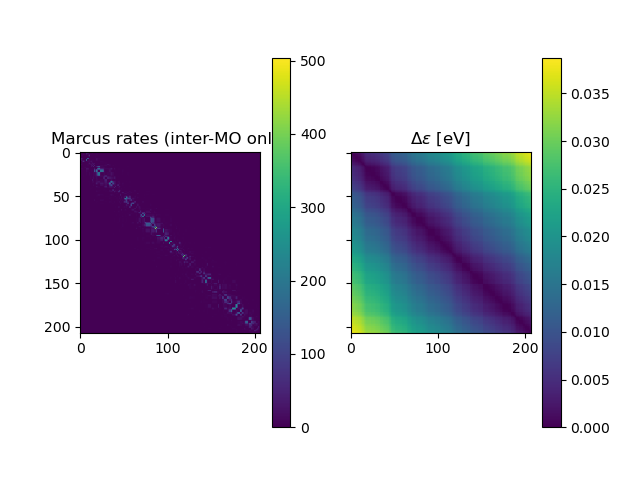

In [ ]:
dE = site_energies[:,None] - site_energies

fig, ax = plt.subplots(1,2,sharey=True)

pcm = ax[0].imshow(K2)
ax[0].set_title('Marcus rates (inter-MO only)')
fig.colorbar(pcm,ax=ax[0])

pcm = ax[1].imshow(np.abs(dE))
ax[1].set_title('$\Delta\\varepsilon$ [eV]')
fig.colorbar(pcm,ax=ax[1])
plt.show()


There doesn't really seem to be very strong correlation between the energy differences and the rates... Sure, the rates tend to be larger for small energy differences, but nothing drastic. Let's now examine the dipole coupling matrix (i.e. $H_{ij}$ in our expression for the Marcus rates).

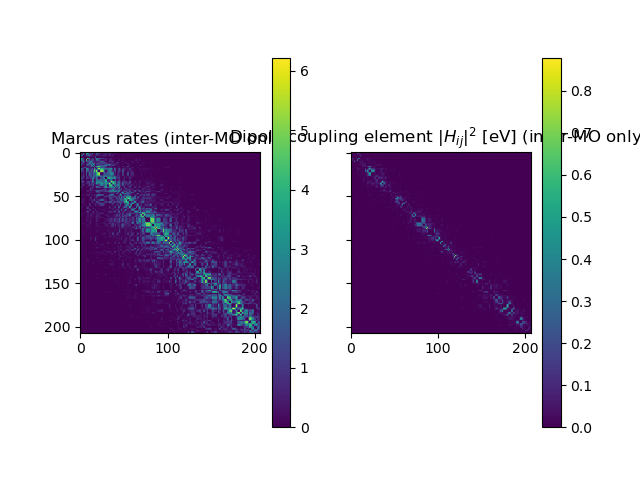

In [ ]:
Js2 = zero_intraMO_rates(Js, site_inds)


fig, ax = plt.subplots(1,2,sharey=True)

pcm = ax[0].imshow(np.log(K2+1))
ax[0].set_title('Marcus rates (inter-MO only)')
fig.colorbar(pcm,ax=ax[0])

pcm = ax[1].imshow(np.log(1+Js2**2))
ax[1].set_title('Dipole coupling element $|H_{ij}|^2$ [eV] (inter-MO only).')
fig.colorbar(pcm,ax=ax[1])
plt.show()

Maximum dipole coupling [eV] =  4809.876674748349
Minimum dipole coupling [eV] =  0.005034060014763578


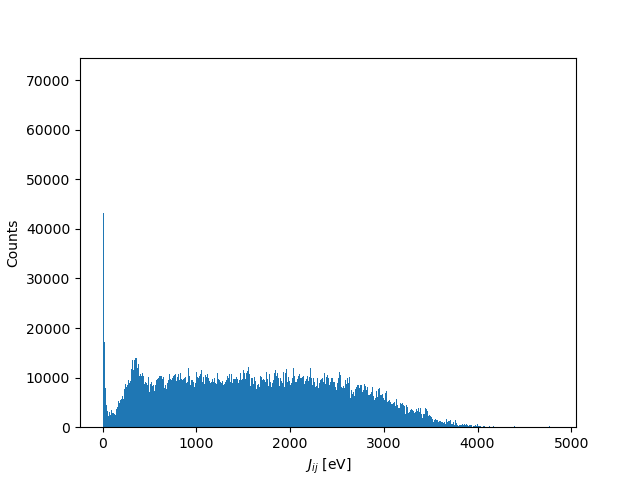

In [ ]:

Jdir = "/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/dipole_couplings/"
percdir = '/Users/nico/Desktop/simulation_outputs/percolation/40x40/percolate_output/'
Jfiles = glob(Jdir+"J*.npy")

bins = np.linspace(0,4810,1001)
hist = np.zeros(1000,dtype=float)
max_J = 0
min_J = np.inf

for jf in Jfiles:
    index = int(jf.split('-')[-1].split('.')[0])
    isites = np.load(percdir + f"sample-{index}/ii.npy")
    js = zero_intraMO_rates(np.load(jf),isites)
    js = np.sort(js[js>0], axis=None) # axis=None flattens the array
    MJ = js[-1]
    mJ = js[0]
    if MJ > max_J: max_J = MJ
    if mJ < min_J: min_J = mJ
    temp_hist, _ = np.histogram(js, bins)
    hist += temp_hist
    

centers  = (bins[1:] + bins[:-1]) / 2
dx = bins[1] - bins[0]
print('Maximum dipole coupling [eV] = ', max_J)
print('Minimum dipole coupling [eV] = ', min_J)

plt.figure()
plt.bar(centers, hist, align='center', width=dx)
plt.xlabel('$J_{ij}$ [eV]')
plt.ylabel('Counts')
plt.show()


Evaluating Marcus rates...
Done!
Fraction of zero elements = 374/30976


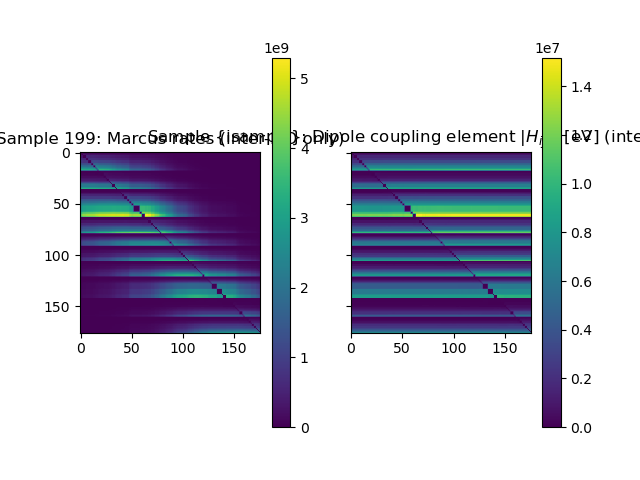

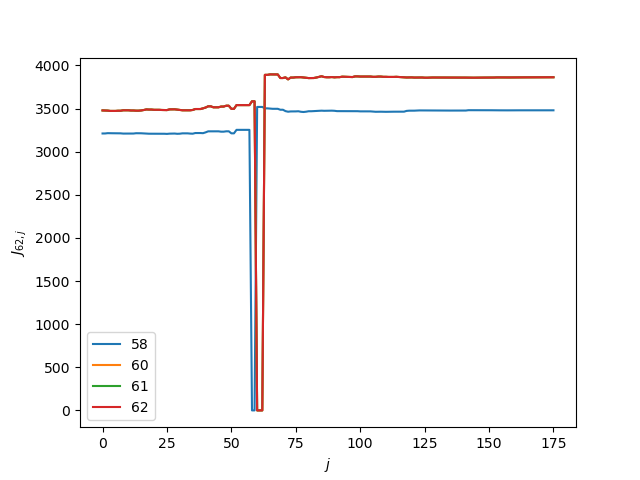

Evaluating Marcus rates...
Done!
Fraction of zero elements = 458/40804


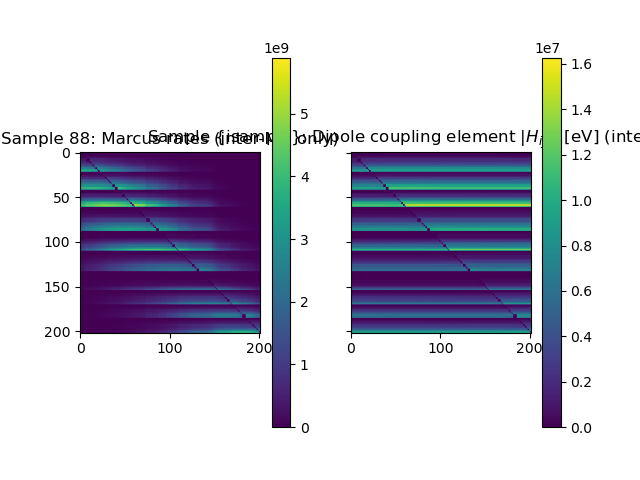

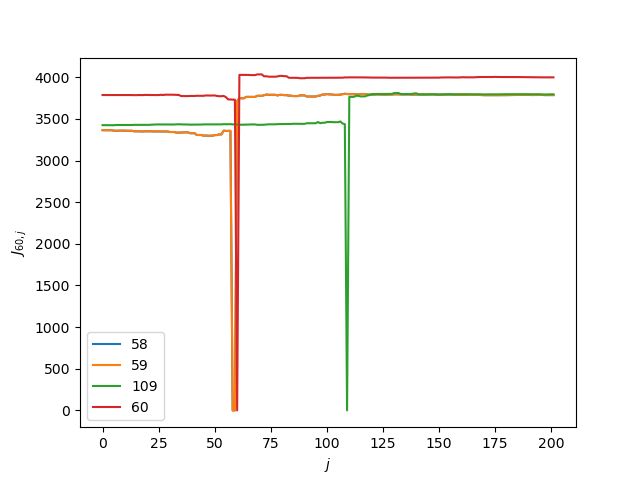

Evaluating Marcus rates...
Done!
Fraction of zero elements = 304/25600


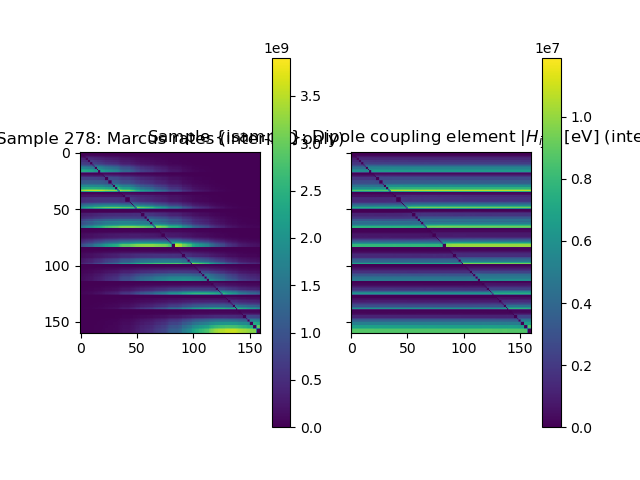

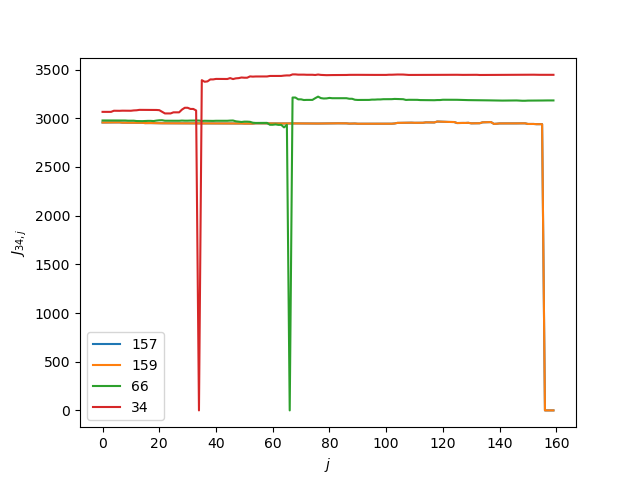

Evaluating Marcus rates...
Done!
Fraction of zero elements = 477/40401


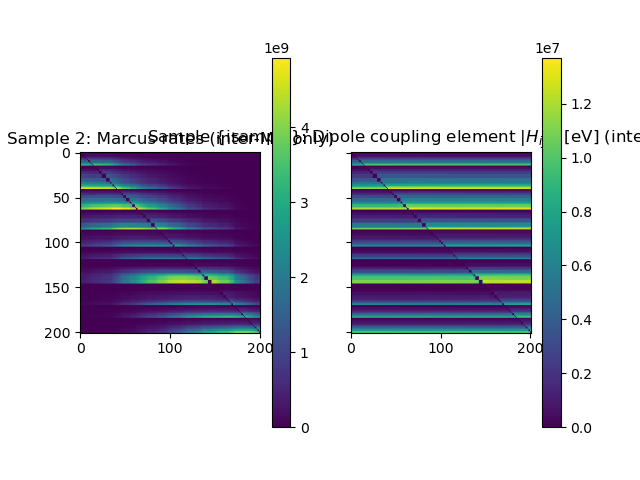

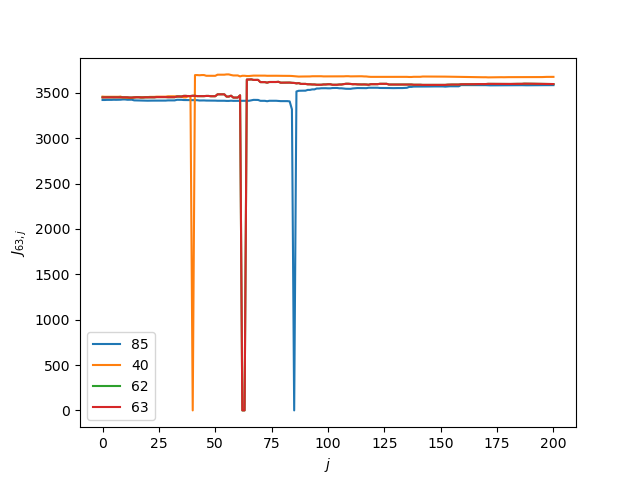

Evaluating Marcus rates...
Done!
Fraction of zero elements = 470/37636


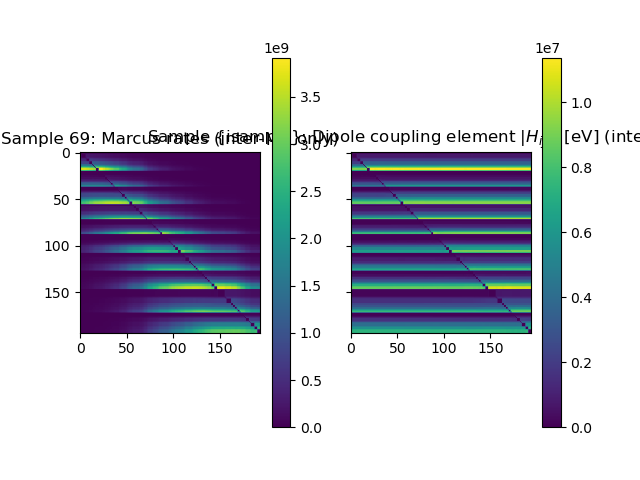

/var/folders/gt/qhbvbx5d1hv7mm6w7y4738c40000gn/T/ipykernel_4070/311446302.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


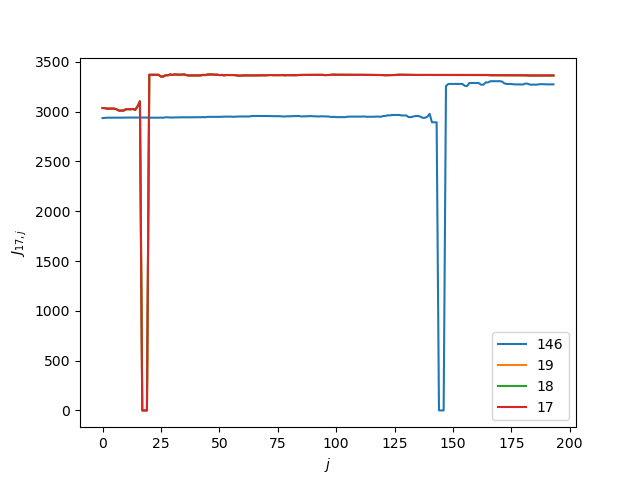

In [ ]:
E = np.zeros(2)


inds = [199, 88, 278, 2, 69]

for isample in inds:
    ee = np.load(percdir + f'sample-{isample}/ee.npy')
    cc = np.load(percdir + f'sample-{isample}/cc.npy')
    ii = np.load(percdir + f'sample-{isample}/ii.npy')
    Jdips = np.load(Jdir + f"Jdip-{isample}.npy")
    Jdips2 = zero_intraMO_rates(Jdips,ii)
    marcus_rates = zero_intraMO_rates(kMarcus_njit(ee,cc,0.005,Jdips,100,E),ii)
    # Jdips = np.load(Jdir + f"jdip-{isample}.npy")
    # marcus_rates = kMarcus_njit(ee,cc,0.005,Jdips,100,E)

    fig, ax = plt.subplots(1,2,sharey=True)

    pcm = ax[0].imshow(marcus_rates)
    ax[0].set_title(f'Sample {isample}: Marcus rates (inter-MO only)')
    fig.colorbar(pcm,ax=ax[0])

    pcm = ax[1].imshow(Jdips2**2)
    ax[1].set_title('Sample {isample}: Dipole coupling element $|H_{ij}|^2$ [eV] (inter-MO only).')
    fig.colorbar(pcm,ax=ax[1])
    plt.show()

    plt.figure()
    for n in np.argsort(Jdips[:,10])[-4:]:
        plt.plot(Jdips[n,:],label=str(n))
        plt.xlabel("$j$")
        plt.ylabel("$J_{%d,j}$"%n)
    plt.legend()
    plt.show()


    


There's something funky happening with my dipole coupling matrices... Let's recompute them locally to see if the issue comes from Narval or from the code. We'll reuse the last `isample` from the previous `for` loop to check this. 

Entering triple for-loop...
Done!


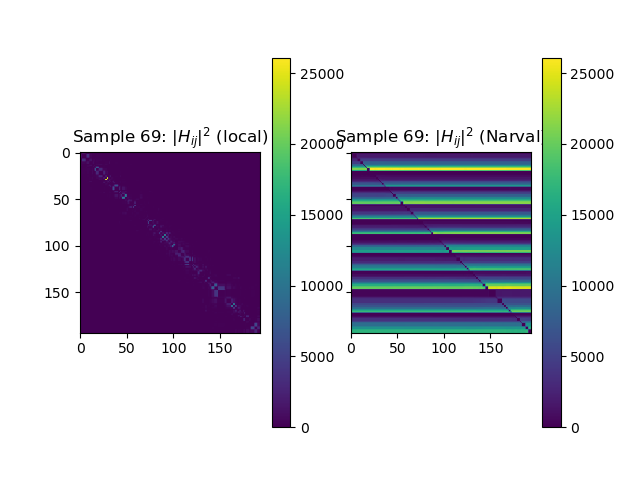

In [ ]:
from qcnico.coords_io import read_xsf
from qcnico.remove_dangling_carbons import remove_dangling_carbons

M = np.load(f"/Users/nico/Desktop/simulation_outputs/percolation/40x40/MOs_ARPACK/MOs_ARPACK_bigMAC-{isample}.npy")
pos, _ = read_xsf(strucdir + f"bigMAC-{isample}_relaxed.xsf")
pos = remove_dangling_carbons(pos,1.8)
np.save(strucdir + f"no_dangle/pos-{isample}_nodangle.npy", pos)
Js_local = zero_intraMO_rates(dipole_coupling(M, pos, ii),ii)

fig, ax = plt.subplots(1,2,sharey=True)

pcm = ax[0].imshow(Js_local**2)
ax[0].set_title(f"Sample {isample}: $|H_{{ij}}|^2$ (local)")
fig.colorbar(pcm,ax=ax[0])
ax[1].imshow(Jdips**2)
ax[1].set_title(f"Sample {isample}: $|H_{{ij}}|^2$ (Narval)")
fig.colorbar(pcm,ax=ax[1])
plt.show()


Ok so it seems that my dipole coupling function is not running properly on Narval. I uploaded a locally computed dipole coupling matrix for a given sample to Narval and re-ran the MC algo using this matrix (instead of the one computed on Narval by the script calling the MC code). Here is what we get:


(87,)


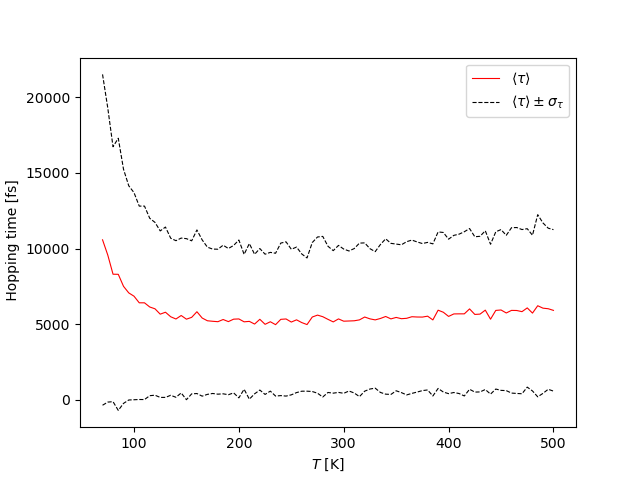

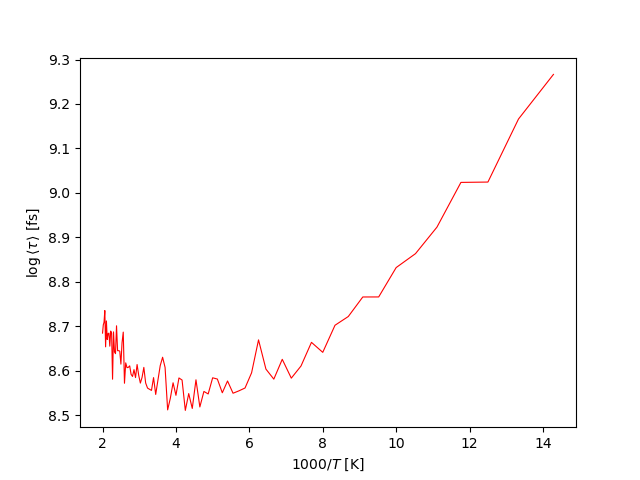

In [ ]:
tpercdir = "/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/percolation_times_dipole/MC_1000/zero_ext_field/"
temps = np.arange(70,505,5,dtype=np.float64)

times = np.zeros_like(temps)
sample_ind = 150
dat = np.load(tpercdir + 'dipole_perc_times-150_zero_field_Jdiv100.npy')
times = np.mean(dat,axis=0)
print(times.shape)
sigma = np.std(dat,axis=0)

# Regular plot
plt.figure()
plt.plot(temps, times, 'r-', lw=0.8,label="$\langle \\tau\\rangle$")
plt.plot(temps, times+sigma, 'k--', lw=0.8,label="$\langle \\tau\\rangle\pm\sigma_\\tau$")
plt.plot(temps, times-sigma, 'k--', lw=0.8)
plt.xlabel("$T$ [K]")
plt.ylabel(" Hopping time [fs]")
plt.legend()
plt.show()

# Arrhenius plot
plt.figure()
plt.plot(1000/temps, np.log(times), 'r-', lw=0.8)
plt.xlabel("$1000/T$ [K]")
plt.ylabel("$\log\langle \\tau\\rangle$ [fs]")
plt.show()

(87,)


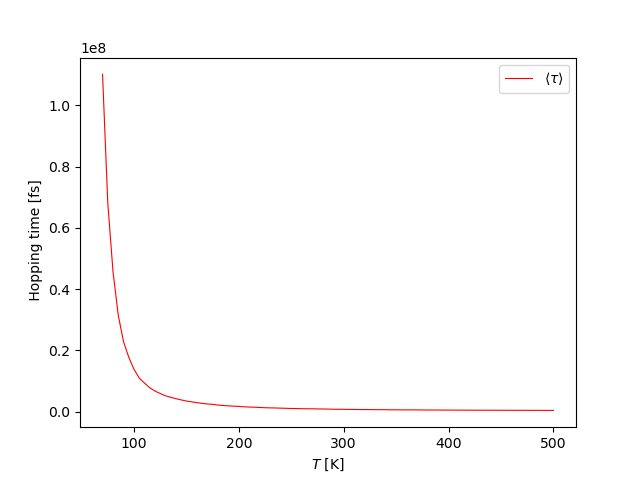

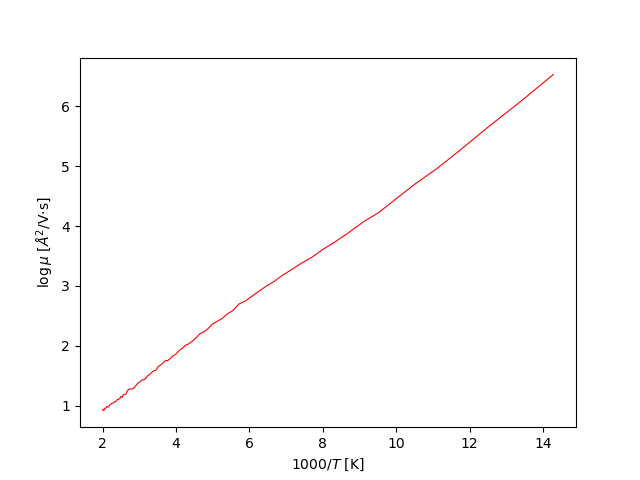

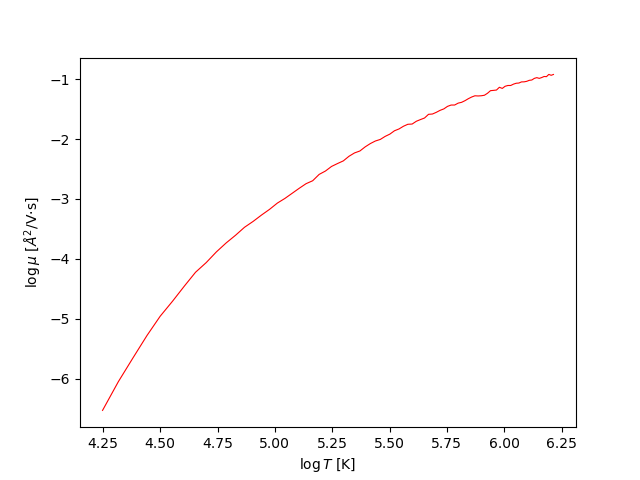

/var/folders/gt/qhbvbx5d1hv7mm6w7y4738c40000gn/T/ipykernel_78251/2486512917.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


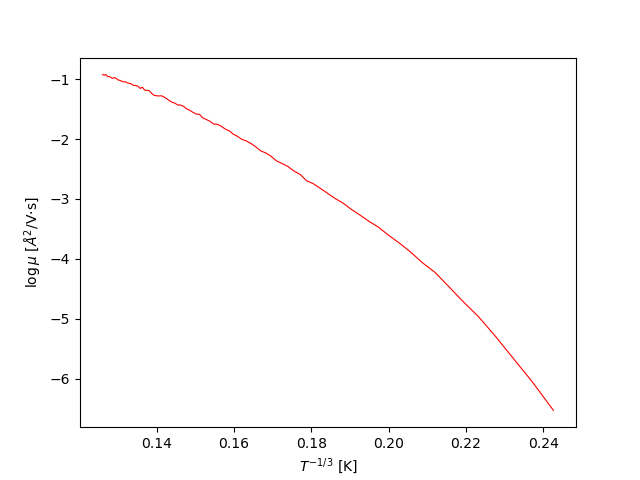

In [13]:

from qcnico.remove_dangling_carbons import remove_dangling_carbons
from qcnico.coords_io import read_xsf

tpercdir = "/Users/nico/Desktop/simulation_outputs/percolation/40x40/monte_carlo/marcus/percolation_times_dipole/MC_1000/"
strucdir = "/Users/nico/Desktop/simulation_outputs/percolation/40x40/structures/"
struc = remove_dangling_carbons(read_xsf(strucdir+'bigMAC-150_relaxed.xsf')[0],1.8)
dX = np.max(struc[:,0]) - np.min(struc[:,0])
E = 1.0/dX
temps = np.arange(70,505,5,dtype=np.float64)

times = np.zeros_like(temps)
sample_ind = 150
dat = np.load(tpercdir + 'dipole_perc_times-150_Jdiv100.npy')
times = np.mean(dat,axis=0)
print(times.shape)
sigma = np.std(dat,axis=0)

# Regular plot
plt.figure()
plt.plot(temps, times, 'r-', lw=0.8,label="$\langle \\tau\\rangle$")
# plt.plot(temps, times+sigma, 'k--', lw=0.8,label="$\langle \\tau\\rangle\pm\sigma_\\tau$")
# plt.plot(temps, times-sigma, 'k--', lw=0.8)
plt.xlabel("$T$ [K]")
plt.ylabel(" Hopping time [fs]")
plt.legend()
plt.show()

# Arrhenius plot
plt.figure()
plt.plot(1000/temps, np.log((E*times)/dX), 'r-', lw=0.8)
plt.xlabel("$1000/T$ [K]")
plt.ylabel("$\log\mu$ [$\AA^2$/V$\cdot$s]")
plt.show()

#
plt.figure()
plt.plot(np.log(temps), np.log(dX/(E*times)), 'r-', lw=0.8)
plt.xlabel("$\log T$ [K]")
plt.ylabel("$\log\mu$ [$\AA^2$/V$\cdot$s]")
plt.show()

plt.figure()
plt.plot(temps**(-1/3), np.log(dX/(E*times)), 'r-', lw=0.8)
plt.xlabel("$T^{-1/3}$ [K]")
plt.ylabel("$\log\mu$ [$\AA^2$/V$\cdot$s]")
plt.show()